In [1]:
# Importing librarires and creating the requred folder for the graphs.
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
import os

FIG_DIR = os.path.join("Results", "figures")
os.makedirs(FIG_DIR, exist_ok=True)


In [2]:
# Assigning constants.
kx = 1
ky = 1
kxy = 0.5
hbar = 1
m = 1
N_t = 10000
N_q = 1200
q_max = 6
A = 1

In [3]:
# Defining graphing functions.
def plot(x, y, xlabel=None, ylabel=None, title=None, label=None,
         show=True, newfig=True, color=None, save=False, dpi=120):
    if newfig:
        plt.figure(figsize=(6, 4), dpi=dpi)
    plt.plot(x, y, color=color, label=label)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save and title:
        safe_title = title.replace(" ", "_")
        plt.savefig(os.path.join(FIG_DIR, f"{safe_title}.png"), dpi=500, bbox_inches="tight")
    if show:
        plt.show()

def plot_on_ax(ax, x, y, xlabel=None, ylabel=None, title=None, color=None, label=None):
    ax.plot(x, y, color=color, label=label)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if label:
        ax.legend()
    ax.grid(True)

In [4]:
# Solving for acceleratins, velocity and positions.
def state(t,state):
    x,y,vx,vy = state
    ax = (-kx*x-kxy*y)/m
    ay = (-ky*y-kxy*x)/m
    return vx,vy,ax,ay
t = np.linspace(0,20,N_t)
state0 = [1,0,0,1]
sol = solve_ivp(state, [0,20], state0, t_eval=t, rtol= 1e-9, atol=1e-12)
x, y, vx, vy = sol.y[0], sol.y[1], sol.y[2],sol.y[3]

# Finding Normal Modes.
k_matrix = np.array([[kx,kxy],
                   [kxy,ky]], dtype = float)
lam, R = np.linalg.eigh(k_matrix)
lambda1, lambda2 = lam
omega = np.sqrt(lam/m)

pos = np.vstack([x,y])
vel = np.vstack([vx,vy])

Q = R.T @ pos
Qdot = R.T @ vel

Q1, Q2 = Q[0], Q[1]
Q1dot, Q2dot = Qdot[0], Qdot[1]

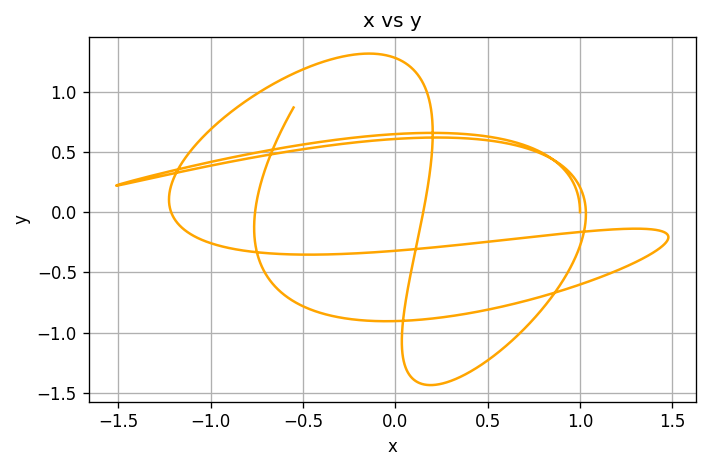

In [5]:
# Position plotting.
plot(x, y, 'x', 'y', 'x vs y', color='orange', show=False)
plt.savefig(os.path.join(FIG_DIR, "xy_trajectory.png"), dpi=500, bbox_inches="tight")
plt.show()

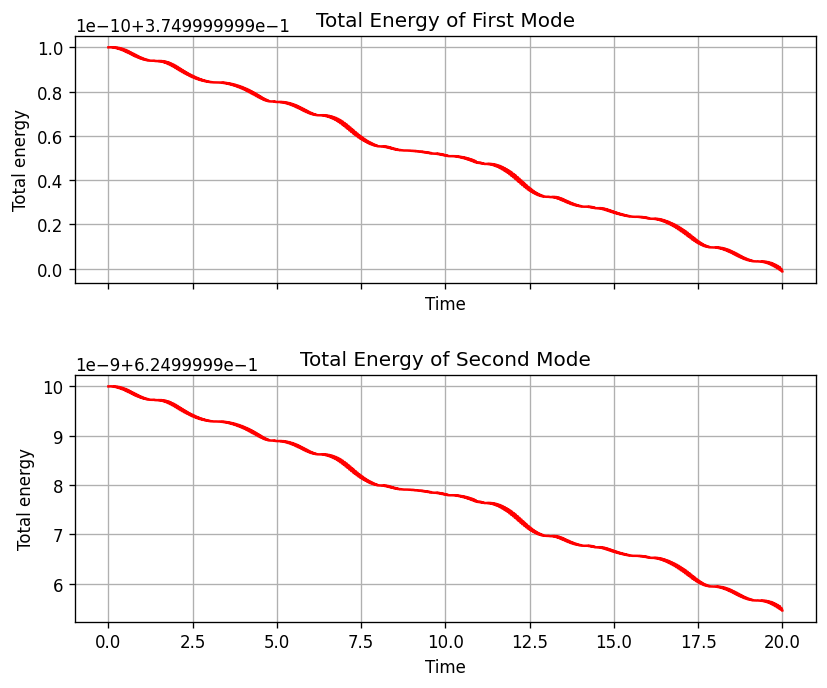

In [6]:
# classical energy of normal modes.
V_Q1 = 0.5 * lambda1 * Q1**2
T_Q1 = 0.5 * m * Q1dot**2
E_Q1 = T_Q1 + V_Q1

V_Q2 = 0.5 * lambda2 * Q2**2
T_Q2 = 0.5 * m * Q2dot**2
E_Q2 = T_Q2 + V_Q2

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 6), dpi=120)
plot_on_ax(ax[0], t, E_Q1, 'Time', 'Total energy', title = 'Total Energy of First Mode', color = 'red')
plot_on_ax(ax[1], t, E_Q2, 'Time', 'Total energy', title = 'Total Energy of Second Mode', color = 'red')

fig.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "Total_Energy_Of_Normal_Modes.png"), dpi=500, bbox_inches="tight")
plt.show()

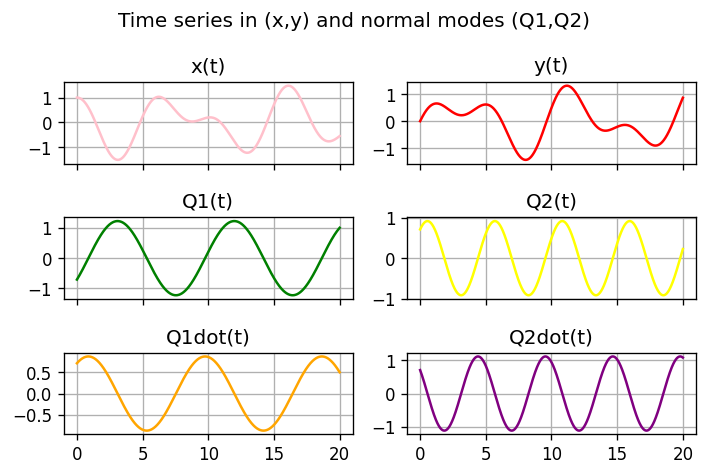

In [7]:
# Plotting time series in (x,y) and normal modes (Q1,Q2).
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(6, 4), dpi=120)

plot_on_ax(ax[0,0],t, x, title = 'x(t)', color = 'pink')
plot_on_ax(ax[0,1], t, y, title = 'y(t)', color = 'red')
plot_on_ax(ax[1,0],t, Q1, title = 'Q1(t)', color = 'green')
plot_on_ax(ax[1,1], t, Q2, title='Q2(t)', color = 'yellow')
plot_on_ax(ax[2,0], t, Q1dot, title='Q1dot(t)', color = 'orange')
plot_on_ax(ax[2,1], t, Q2dot, title='Q2dot(t)', color = 'purple')

fig.suptitle('Time series in (x,y) and normal modes (Q1,Q2)')
fig.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "Time_series_and_normal_modes.png"), dpi=500, bbox_inches="tight")
plt.show()

In [8]:
# Making uniform grid space and defining the finite difference second derivative operator.
q = np.linspace(-q_max, q_max, N_q)
dq = q[1]-q[0]

main = -2.0 * np.ones(N_q)
off = 1.0 * np.ones(N_q - 1)

diff = diags([off, main, off], offsets=[-1, 0, 1], format='csr') / (dq**2)

In [9]:
# solving the 1d eigenproblem for a given mode and getting the wavefucntion.

def solve_mode(lambda_i, mode_name, numstates=4):
    """Solve the 1D quantum eigenproblem for a normal mode with an anharmonic correction."""
    # Anharmonic potential: quadratic + quartic in coordinate
    V = 0.5 * lambda_i * q**2 + A * q**4
    V_op = diags(V, 0, format='csr')

    # Kinetic operator: -(ħ^2/2m) d^2/dq^2
    T_op = -(hbar**2) / (2*m) * diff

    H_op = T_op + V_op

    # Smallest algebraic eigenvalues = lowest energies
    E, psi = eigsh(H_op, k=numstates, which='SA')

    idx = np.argsort(E)
    E = E[idx]
    psi = psi[:, idx]

    # Normalize each eigenvector: sum |psi|^2 dq = 1
    for j in range(psi.shape[1]):
        norm = np.sqrt(np.sum(np.abs(psi[:, j])**2) * dq)
        psi[:, j] /= norm

    print(f"\n{mode_name}: lambda={lambda_i:.6g}, omega={np.sqrt(lambda_i/m):.6g}")
    for i in range(numstates):
        print(f"n={i}, energy={E[i]:.6g}")
    return E, psi

E1, psi1 = solve_mode(lambda1, 'Mode1')
E2, psi2 = solve_mode(lambda2, 'Mode2')


Mode1: lambda=0.5, omega=0.707107
n=0, energy=0.737751
n=1, energy=2.56898
n=2, energy=4.94064
n=3, energy=7.64138

Mode2: lambda=1.5, omega=1.22474
n=0, energy=0.866463
n=1, energy=2.90061
n=2, energy=5.41191
n=3, energy=8.23667


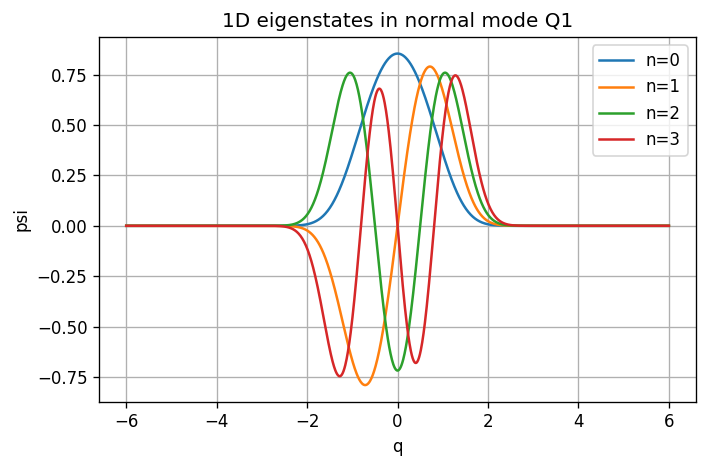

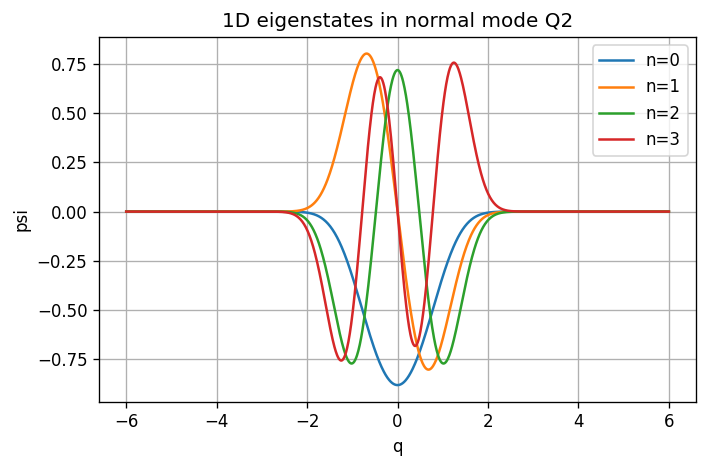

In [10]:
# Plot eigenfunctions: one figure for Q1, one figure for Q2
for n in range(4):
    plot(q, psi1[:, n], xlabel='q', ylabel='psi', title='1D eigenstates in normal mode Q1',
         label=f'n={n}', newfig=(n == 0), show=False)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "Q1_eigenstates.png"), dpi=300, bbox_inches="tight")
plt.show()

for n in range(4):
    plot(q, psi2[:, n], xlabel='q', ylabel='psi', title='1D eigenstates in normal mode Q2',
         label=f'n={n}', newfig=(n == 0), show=False)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "Q2_eigenstates.png"), dpi=500, bbox_inches="tight")
plt.show()

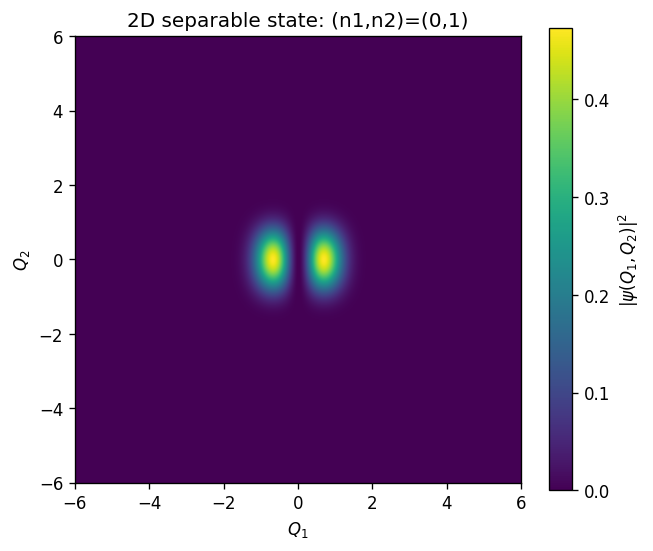

In [11]:
# Example 2D separable probability density in (Q1,Q2): |psi_{n1}(Q1) psi_{n2}(Q2)|^2
n1, n2 = 0, 1
Psi2d =np.outer(psi1[:,n1],psi2[:,n2])
Prob2d = np.abs(Psi2d)**2

plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(Prob2d, extent=[-q_max, q_max, -q_max, q_max], origin='lower', aspect='equal')
plt.colorbar(label=r'$|\psi(Q_1,Q_2)|^2$')
plt.xlabel(r'$Q_1$')
plt.ylabel(r'$Q_2$')
plt.title(f'2D separable state: (n1,n2)=({n1},{n2})')
plt.savefig(os.path.join(FIG_DIR, "2D_probability.png"), dpi=500, bbox_inches="tight")
plt.show()